In [22]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Documents/Hamburg/galerkin/assigment5`


In [23]:
author="el barto"

"el barto"

In [24]:
using Trixi
using Trixi2Vtk
using OrdinaryDiffEq
using Plots
using LinearAlgebra

In [25]:
#here i defined a flux for godunov for the case when a=1, so it works for this assignment but it shouldn't use it for general cases

function flux_godunoob(ull, urr, val_a, equations)
    if val_a < 0.0 return urr
    else return ull
    end
end



flux_godunoob (generic function with 1 method)

In [26]:

function ex03(polydeg,n_elem, flux)
    x_lim_inf = -1.0 #lim inf of the set of integration
    x_lim_sup = 1.0 #lim sup
    
    
    initial_cond(x) = sin(pi * x); #the function for initial condition
    #the number of elements how we want to split the domain, received in the arguments of the function
    dx=(x_lim_sup-x_lim_inf)/n_elem
    
    
    basis = LobattoLegendreBasis(polydeg)
    nodes = basis.nodes # Gauss-Lobatto nodes in [-1, 1]
    D = basis.derivative_matrix
    M = diagm(basis.weights) # mass matrix
    B = diagm([-1; zeros(polydeg - 1); 1])
    
    x = Matrix{Float64}(undef, length(nodes), n_elem)
    #making the reference coordinates 
for j in 1:n_elem
    x_l = -1 + (j - 1) * dx + dx/2
    for i in 1:length(nodes) # basis points in [-1, 1]
        ξ = nodes[i]
        x[i, j] = x_l + dx/2 * ξ
    end
end

    
        u0=initial_cond.(x)
    
    surface_flux = flux
    
    # rhs! method
function rhs!(du, u, x, t)
    # reset du
    du .= zero(eltype(du))
    flux_numerical = copy(du)

    # calculate interface and boundary fluxes
    equations = LinearScalarAdvectionEquation1D(1.0)
    for element in 2:n_elem-1
        # left interface
        flux_numerical[1, element] = surface_flux(u[end, element-1], u[1, element], 1, equations)
        flux_numerical[end, element-1] = flux_numerical[1, element]
        # right interface
        flux_numerical[end, element] = surface_flux(u[end, element], u[1, element+1], 1, equations)
        flux_numerical[1, element+1] = flux_numerical[end, element]
    end
    # boundary flux
    flux_numerical[1, 1] = surface_flux(u[end, end], u[1, 1], 1, equations)
        flux_numerical[end, end] = flux_numerical[1, 1] #here we set the periodic boudary conditions 

    # calculate surface integrals
    for element in 1:n_elem
        du[:, element] -= (M \ B) * flux_numerical[:, element]
    end

    # calculate volume integral
    for element in 1:n_elem
        flux = u[:, element]
        du[:, element] += (M \ transpose(D)) * M * flux
    end

    # apply Jacobian from mapping to reference element
    for element in 1:n_elem
        du[:, element] *= 2 / dx
    end

    return nothing
end
    # create ODE problem
    tspan = (0.0, 2.5)
    ode = ODEProblem(rhs!, u0, tspan, x)

    # solve
    sol = solve(ode, RDPK3SpFSAL49(), abstol=1.0e-6, reltol=1.0e-6, save_everystep=true)
    
    
    return x, sol

end

ex03 (generic function with 1 method)

In [27]:
function visual_ex03(n,degre)
    xx,solu =ex03(degre,n,flux_godunoob);
    x,sol =ex03(degre,n,flux_central);
    tspan = (0.0, 2.5)
    #we will save the picture of the last element of the solution, i.e. when t=2.5
    pl=plot(vec(xx), vec(solu.u[end]), label="solution at t=$(tspan[2]) godunov", legend=:topleft, lw=3, xlabel="x", ylabel="u", title="pol_degre=$(degre) & number elements =$(n)")
    plot!(vec(x), vec(sol.u[end]), label="solution at t=$(tspan[2]) central", lw=3)
    
   savefig(pl,"plot.png")
    
    pl
end
    

visual_ex03 (generic function with 1 method)

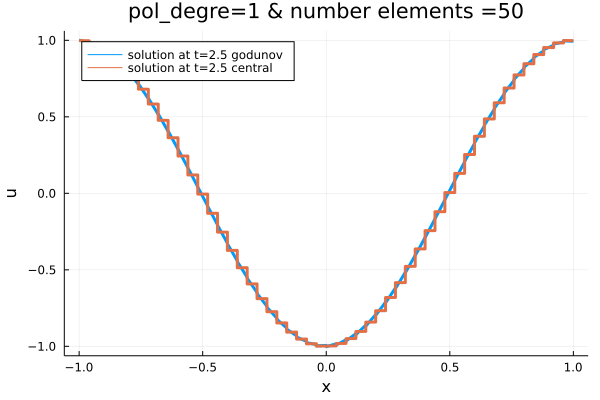

In [33]:
visual_ex03(50,1)